In [32]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from joblib import dump
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    classification_report,
    precision_recall_fscore_support,
    make_scorer,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

<h1>Desarrollo de un modelo predictivo sobre fraude en transacciones basadas en el uso de tarjetas de crédito</h1>

<h2>Carga de los datos</h2>

<p>La información que se ha proporcionado para la elaboración de este trabajo ha sido supervisada y validada por los expertos en el dominio del negocio. Estos datos han sido procesados mediante técnicas de reducción de dimensionalidad (PCA) y se encuentren normalizados. Los valores de las columnas se encuentran anonimizados. Para la elaboración de este informe se ha proporcionado un fichero con extensión CSV que contiene todos los datos que se van a utilizar.</p>

<p>En otros escenarios tendríamos que utilizar algún tipo de conexión a una base de datos o utilizar tecnologías de procesamiento de datos masivos pero en este caso basta con realizar una carga simple del fichero: <code>creditcard.csv</code>. En caso de pérdida es posible descargar una copia desde el <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">siguiente</a> enlace. Una vez descargado basta con descomprimir el fichero y extraer el contenido en el directorio raíz desde donde se va a ejecutar este <i>notebook</i>.</p>

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h2>Análisis descriptivo</h2>

<p>En este apartado del informe procederemos a realizar un análisis de la calidad de los datos de entrada. El objetivo de este estudio será extraer todo el conocimiento posible de la información para así poder aplicar técnicas que mejoren su calidad o detectar posibles anomalías que puedan hacer que la eficiencia del modelo final se vea afectada.</p>

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

<p>El juego de datos se ha cargado correctamente y los nombres de las columnas son los que originalmente hemos observado en el fichero de entrada original.</p>

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<p>Analizando la tabla anterior podemos comprobar que la suposición inicial, es decir, que las columnas con valores anónimos se encuentran escaladas es cierta. Vemos que el resto de columnas que no representan la clase (<strong>Amount</strong> y <strong>Time</strong>) no han sido procesadas.</p>

In [5]:
print(f'Null values: {df.isnull().sum().max()}')

Null values: 0


<p>El resultado anterior nos indica que no existen valores nulos en el juego de datos por lo que no será necesario realizar ningún preprocesamiento para compensarlo.</p>

<AxesSubplot:xlabel='Class', ylabel='count'>

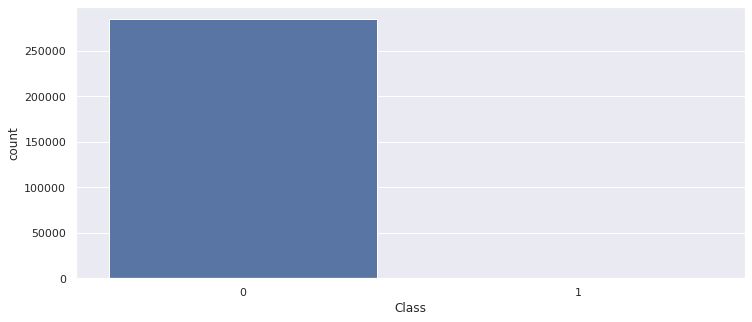

In [6]:
sns.set(rc={
    'figure.figsize': (12, 5)
})
sns.countplot(x='Class', data=df)

In [7]:
ROUND_PERCENT = 3

def get_dataset_info(dataframe, prec=ROUND_PERCENT):
    legit_count, fraud_count = dataframe['Class'].value_counts()
    total_count, total_cols = dataframe.shape
    info = {
        'legit transactions percent': f'{round((legit_count / total_count) * 100, prec)}%',
        'fraud transactions percent': f'{round((fraud_count / total_count) * 100, prec)}%',
        'total transactions': total_count,
        'total columns': total_cols,
        'total legit transactions count': legit_count,
        'total fraud transactions count': fraud_count,
    }

    return pd.DataFrame(info.values(), index=info.keys())


display(get_dataset_info(dataframe=df))

,0
legit transactions percent,99.827%
fraud transactions percent,0.173%
total transactions,284807
total columns,31
total legit transactions count,284315
total fraud transactions count,492


<p>Podemos ver que, en efecto, el juego de datos original se encuentra muy desbalanceado. Para compensar este defecto tendremos que utilizar técnicas de balanceo de datos como <i>undersampling</i> o <i>oversampling</i> para que el modelo resultante tenga la máxima calidad posible.</p>

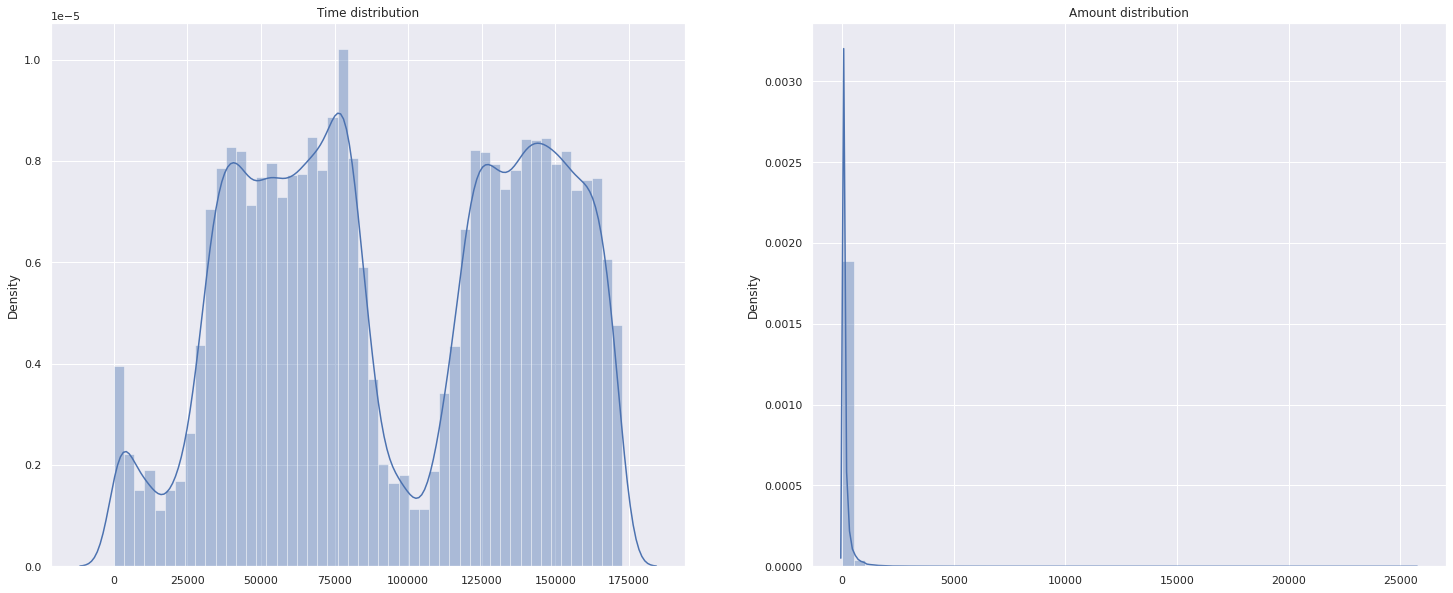

In [8]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25, 10)
)

for col, ax in zip(('Time', 'Amount'), axes.flat):
    ax.set_title(f'{col} distribution')
    sns.distplot(x=df[col], ax=ax)
plt.show()

<p>Como conclusión de este apartado: </p>
<ul>
    <li>El juego de datos se encuentra muy desbalanceado con:</li>
    <ul>
        <li>Número total de transacciones: <code>284807</code></li>
        <li>Transacciones legítimas: <code>284315 - 99.827% </code></li>
        <li>Transacciones fraudulentas: <code>492 - 0.173%</code></li>
    </ul>
    <li>La cantidad de observaciones en el juego de datos no es muy elevada: <code>284807</code></li>
    <li>No existen valores nulos.</li>
    <li>El juego de datos tiene 31 columnas:</li>
    <ul>
        <li>28 columnas anonimizadas y normalizadas con nombres desde V1 a V28.</li>
        <li><strong>Time:</strong> tiempo transcurrido desde la primera transacción.</li>
        <li><strong>Amount:</strong> cantidad de la transacción en dólares (USD).</li>
            <ul>
                <li>Analizando los gráficos podemos concluir que se trata de transacciones con cantidades muy pequeñas.</li>
            </ul>
        <li><strong>Class:</strong> categoría de la transacción. </li>
        <ul>
            <li>0: transacción correcta.</li>
            <li>1: transacción fraudulenta.</li>
        </ul>
    </ul>
</ul>

<p>Como se trata de un juego de datos desbalanceado a la hora de evaluar la eficiencia de los modelos no podremos utilizar <i>accuracy</i> ya que podría llevarnos a resultados erróneos. Tendremos que utilizar matrices de confusión, <i>f1-score</i> o <i>precision/recall</i>.</p>


<h2>Normalización de <strong>Amount</strong> y <strong>Time</strong></h2>

<p>Como hemos comentado en apartados anteriores las columnas <strong>Amount</strong> y <strong>Time</strong> no se encuentran normalizadas por lo que en este apartado realizaremos la normalización de las mismas. Para conservar los datos de las columnas originales crearemos dos nuevas con los nombres <strong>ScaledTime</strong> y <strong>ScaledAmount</strong>. Antes de realizar este proceso procederemos a analizar la distribución de ambas columas para ver qué cantidad de valores extremos o <i>outliers</i> y así elegir el mejor método de escalado.</p>

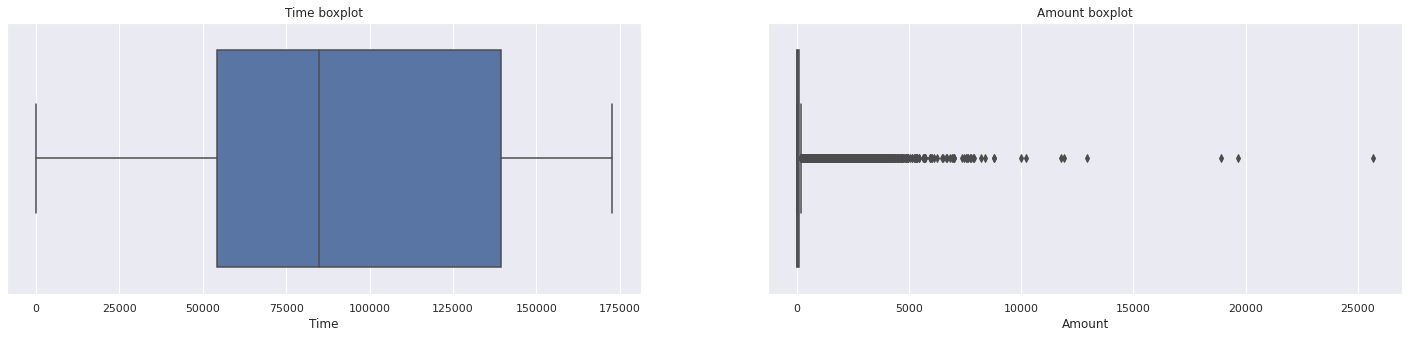

In [9]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25, 5)
)

for col, ax in zip(('Time', 'Amount'), axes.flat):
    ax.set_title(f'{col} boxplot')
    sns.boxplot(x=df[col], ax=ax)
plt.show()

<p>Como vemos en los gráficos anteriores la columna <strong>Amount</strong> parece que presenta algunos valores extremos en su distribución en las partes altas por lo que vamos a utilizar <i>RobustScaler</i> ya que es más robusto ante este tipo de situaciones ya que utiliza la mediana y el rango intercuantil en vez de la media y la varianza.</p>


In [10]:
robust_scaler = RobustScaler()

for scaled_col, original_col in zip(
        ('ScaledAmount', 'ScaledTime'),
        ('Amount', 'Time')):
    df[scaled_col] = robust_scaler.fit_transform(df[original_col].values.reshape(-1, 1))

df[['ScaledAmount', 'Amount', 'ScaledTime', 'Time', 'Class']].sample(10).head()

,ScaledAmount,Amount,ScaledTime,Time,Class
127574,1.089918,100.00,-0.074155,78380.0,0
12307,-0.294977,0.89,-0.741961,21537.0,0
142609,-0.296793,0.76,0.001539,84823.0,0
281620,-0.244673,4.49,1.005874,170311.0,0
267004,5.337106,403.95,0.914978,162574.0,0


In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,ScaledAmount,ScaledTime
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,0.927124,0.118914
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,3.495006,0.557903
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-0.307413,-0.994983
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,-0.229162,-0.358210
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,0.770838,0.641790
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,358.683155,1.035022



<p>Como podemos comprobar el juego de datos original ahora contiene las columnas <strong>ScaledAmount</strong> y <strong>ScaledTime</strong>. Para seguir con el siguiente paso del análisis se van a eliminar las columnas originales <strong>Amount</strong> y <strong>Time</strong></p>


In [12]:
df.drop(['Amount', 'Time'], axis=1, inplace=True)
df.rename(
    columns={
        'ScaledAmount': 'Amount',
        'ScaledTime': 'Time'
    },
    inplace=True
)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount,Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


<h2>Particionado de los datos</h2>
<p>Antes de proceder a procesar la información con técnicas de balanceo de datos es necesario particionarlos antes. Aunque estos datos van a particionarse de la misma forma cuando generemos los juegos de datos balanceados las pruebas han de hacerse con el juego de datos original. El objetivo final es entrenar los modelos con los juegos de datos después de aplicar técnicas de <i>oversampling</i> o <i>undersampling</i> y hacer las pruebas con el juego de datos original. En este caso utilizaremos un particionado de 80/20 siendo 80% el juego de datos de entrenamiento y 20% el de pruebas.</p>



In [13]:
TEST_SIZE = 0.2
RANDOM_STATE = 1

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


<h2>Creación de muestras balanceadas</h2>

<p>Para continuar con el análisis del juego de datos original es necesario crearmuestras balanceadas. Para tener un juego de datos con la misma cantidad de transacciones fraudulentas y legítimas es necesario extraer la información necesaria del fichero proporcionado. Debemos hacer este proceso ya que si se utiliza el juego de datos original podremos tener los siguientes problemas:</p>
<ul>
    <li><strong>Correlaciones erróneas:</strong> aunque la mayoría de las columnas se encuentran anonimizadas podría ser interesante conocer las correlaciones entre estas. Si utilizamos un juego de datos desbalanceado no podremos obtener esta información de forma fiable.</li>
    <li><strong><i>Overfitting:</i></strong> si se utiliza el juego de datos tal cual se ha obtenido originalmente los modelos se sobreentrenarán con los casos de transacciones legítimas haciendo que las fraudulentas no puedan ser detectadas con la eficiencia necesaria.</li>
</ul>

<h3>Undersampling</h3>
<p>Este tipo de técnicas realiza un procesado de los datos de tal forma que balancea la muestra original teniendo en cuenta la clase menos representada. Esto significa que las clases más representadas verán reducida la cantidad de filas para adecuarse en número a las clases menos representadas. En concreto vamos a utilizar los siguientes algoritmos:</p>
<ul>
    <li><i>Random undersampling</i></li>
    <li><i>NearMiss</i></li>
</ul>
<p>Para cada uno de ellos explicaremos su funcionamiento en líneas generales y mostraremos información sobre el juego de datos resultante.</p>

<h3>Oversampling</h3>
<p>Este tipo de técnicas realiza un procesado de los datos de tal forma que balancea la muestra original teniendo en cuenta la clase más representada representada. Esto significa que las clases menos representadas aumentarán la cantidad de filas para adecuarse en número a las clases más representadas. En concreto vamos a utilizar los siguientes algoritmos:</p>
<ul>
    <li><i>Random oversampling</i></li>
    <li>ADASYN</li>
    <li>SMOTE</li>
</ul>

<p>En este apartado probaremos todos los algoritmos seleccionamos para la generación de muestras y analizaremos los resultados. De esta forma podremos comprobar qué hace realmente cada uno de ellos y analizaremos el resultado de cada uno de ellos con respecto al juego de datos original del análisis descriptivo.</p>

In [14]:
RANDOM_N = 1

SAMPLERS = [
    ('Random Under Sampling', RandomUnderSampler, RANDOM_STATE, 'majority'),
    ('NearMiss', NearMiss, None, 'majority'),
    ('Random Over Sampling', RandomOverSampler, RANDOM_STATE, 'minority'),
    ('SMOTE', SMOTE, RANDOM_STATE, 'minority'),
    ('ADASYN', ADASYN, RANDOM_STATE, 'minority'),
]

# Save samplers data for visualizations
samplers_df = {}

def get_sampled_dataframe(sampler_instance, random_state, sampling_strategy):
    sampler = sampler_instance(
        random_state=random_state,
        sampling_strategy=sampling_strategy,
    ) if random_state is not None else sampler_instance(
        sampling_strategy=sampling_strategy
    )
    X_sampled, y_sampled = sampler.fit_resample(X, y)
    df_sampled = X_sampled
    df_sampled['Class'] = y_sampled

    return df_sampled


for sampler_name, sampler, random_state, sampling_strategy in SAMPLERS:
    df_sampled = get_sampled_dataframe(
        sampler_instance=sampler,
        random_state=random_state,
        sampling_strategy=sampling_strategy,
    )
    samplers_df.update({
        sampler_name: df_sampled
    })

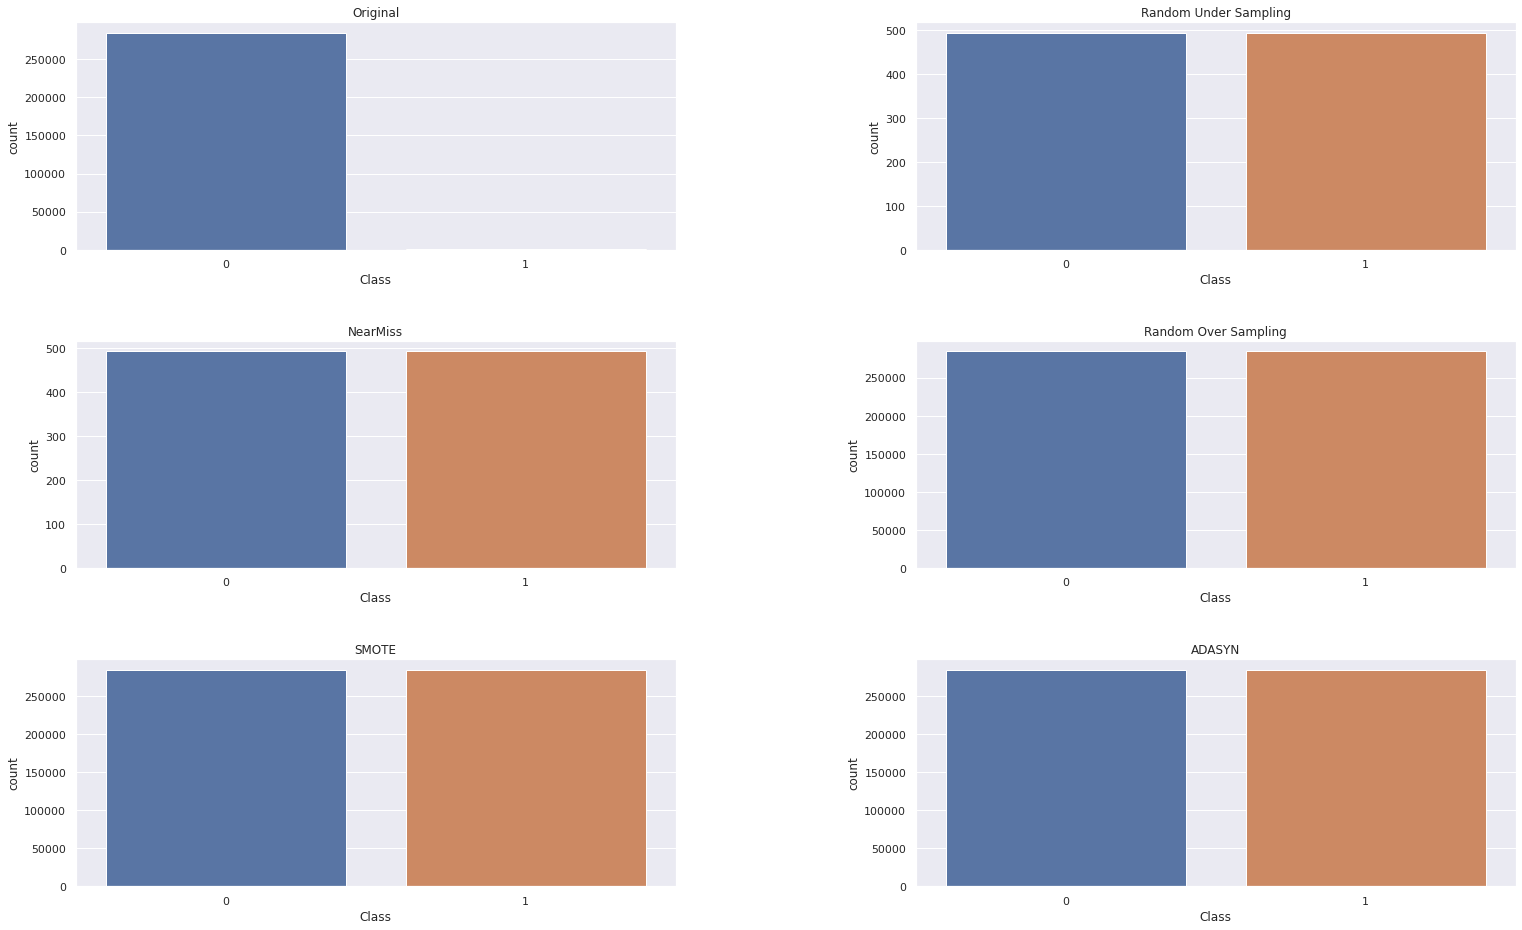

In [15]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(25, 15)
)

samplers_names = ['Original'] + list(samplers_df.keys())
samplers_data = [df] + list(samplers_df.values())

for col, dataframe, ax in zip(samplers_names, samplers_data, axes.flat):
    ax.set_title(f'{col}')
    sns.countplot(x='Class', ax=ax, data=dataframe)

plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.4,
    hspace=0.4,
)
plt.show()

<p>Vemos que, efectivamente, los algoritmos que realizar <i>undersampling</i> reducen la clase que más representación tiene para que tenga el mismo número que la infrarepresentada y los que aplican <i>oversampling</i> realizan justo lo contrario: aumentan la muestra de la clase con menos filas para que se iguale a la que mayor número de filas tiene. A continuación vamos a visualizar las correlaciones de las variables para cada uno de ellos. De esta forma podremos obtener un mayor conocimiento del juego de datos y de cómo ha influído cada técnica en las correlaciones entre las diferentes columnas.</p>

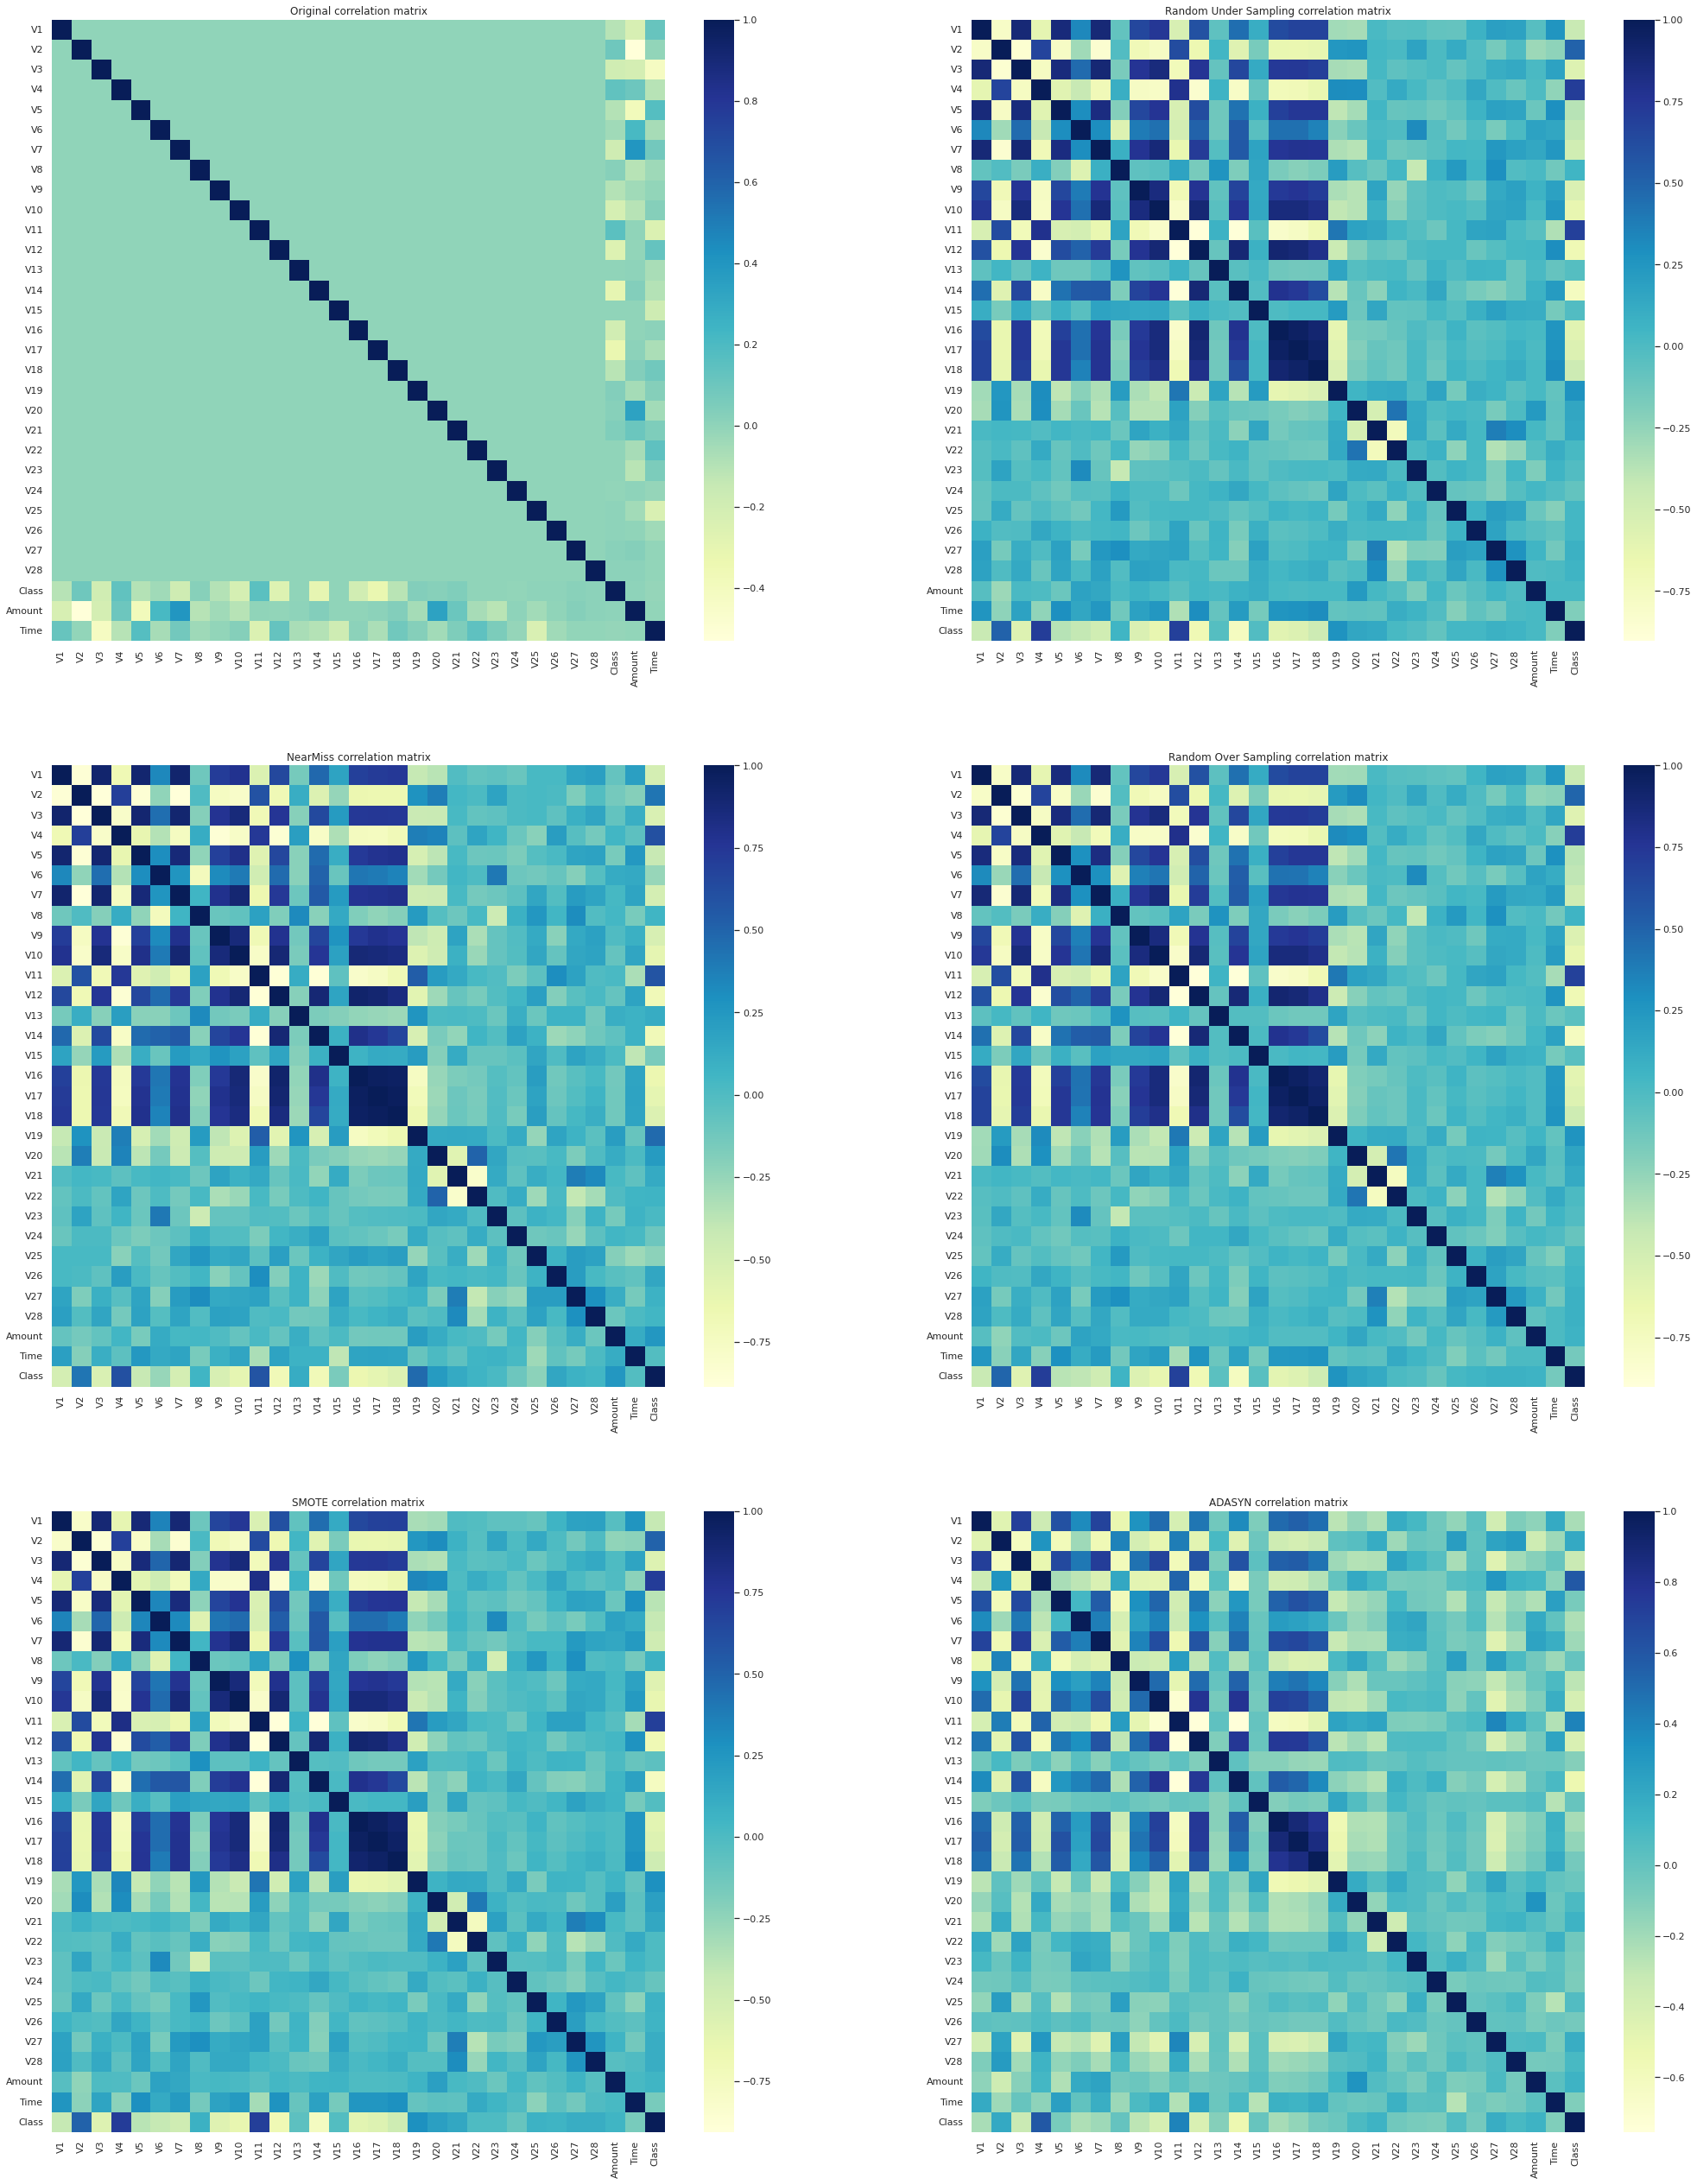

In [16]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(35, 45)
)

samplers_names = ['Original'] + list(samplers_df.keys())
samplers_data = [df] + list(samplers_df.values())

for col, dataframe, ax in zip(samplers_names, samplers_data, axes.flat):
    ax.set_title(f'{col} correlation matrix')
    sns.heatmap(data=dataframe.corr(), ax=ax, cmap='YlGnBu')

plt.show()


<p>Observando la matriz anterior podemos obtener las siguientes conclusiones:</p>
<ul>
    <li>Correlación positiva: las columnas <strong>V2</strong>, <strong>V4</strong>, <strong>V11</strong> y <strong>V19</strong> están correlacionadas positivamente con el valor de la clase. Esto significa que cuanto mayor sean estos valores mayor probabilidad de que la transacción sea fraudulenta.</li>
    <li>Correlación negativa. las columnas <strong>V10</strong>, <strong>V12</strong>, <strong>V14</strong> y <strong>V17</strong> están correlacionadas negativamente con el valor de la clase. Esto significa que cuanto menor sean estos valores mayor probabilidad de que la transacción sea fraudulenta.</li>
</ul>


<h2>Selección de clasificadores</h2>
<p>Una vez hemos analizado y probado cada uno de los algoritmos de muestreo que vamos a utilizar en este informe en este apartado vamos a realizar un entrenamiento, sin ajuste de hiperparámetros, para cada uno de los modelos elegidos. Como en este punto ya tenemos el juego de datos original particionado crearemos un <i>pipeline</i> que cree una muestra con cada uno de los algoritmos del apartado anterior y entrenaremos un clasificador. Los clasificadores que se han seleccionado para la elaboración de este trabajo son los siguientes:</p>
<ul>
    <li>LogisticRegression</li>
    <li>KNN</li>
    <li>DecisionTree</li>
    <li>IsolationForest</li>
</ul>
<p>Según se ha podido estudiar en la literatura existente cada uno de estos clasificadores puede resolver el problema que intentamos atajar, esto es, la clasificación correcta de transacciones fraudulentas de tarjetas de crédito en un juego de datos desbalanceado. Para cada uno de ellos mostraremos un reporte con el resultado de la clasificación. La finalidad de este apartado es seleccionar los mejores modelos y obtener los <i>baseline</i> para, a partir de sus resultados, intentar optimizar sus hiperparámetros a posteriori.</p>

In [17]:
def instantiate_clf(classifier_info):
    classifier_name, model, model_random_state, n_jobs, other = classifier_info

    model_instance = None

    if model_random_state is None and n_jobs is not None:
        model_instance = model(n_jobs=n_jobs)
    elif model_random_state is not None and n_jobs is not None:
        if classifier_name != 'Logistic Regression':
            model_instance = model(random_state=model_random_state, n_jobs=n_jobs)
        else:
            model_instance = model(random_state=model_random_state, n_jobs=n_jobs, max_iter=other)
    elif model_random_state is not None and n_jobs is None:
        model_instance = model(random_state=model_random_state)

    return classifier_name, model_instance

def instantiate_sampler(sampler_info):
    sampler_name, sampler, sampler_random_state, sampling_strategy = sampler_info

    sampler_instance = None

    sampler_instance = sampler(
        sampling_strategy=sampling_strategy
    ) if sampler_random_state is None else sampler(
        random_state=sampler_random_state,
        sampling_strategy=sampling_strategy
    )

    return sampler_name, sampler_instance

In [18]:
RANDOM_STATE = 1

CLASSIFIERS = [
    ('Logistic Regression', LogisticRegression, RANDOM_STATE, -1, 500),
    ('K-Nearest Neighbors', KNeighborsClassifier, None, -1, None),
    ('Decision Tree', DecisionTreeClassifier, RANDOM_STATE, None, None),
]

for classifier_info in CLASSIFIERS:
    for sampler_info in SAMPLERS:

        classifier_name, classifier_instance = instantiate_clf(classifier_info)
        sampler_name, sampler_instance = instantiate_sampler(sampler_info)

        pipeline = Pipeline([
            (sampler_name, sampler_instance),
            (classifier_name, classifier_instance),
        ])

        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f' === Classification report for {classifier_name} using {sampler_name} === ')
        print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

print('DONE')

 === Classification report for Logistic Regression using Random Under Sampling === 
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.98     56875
       Fraud       0.04      0.90      0.08        87

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962

 === Classification report for Logistic Regression using NearMiss === 
              precision    recall  f1-score   support

       Legit       1.00      0.55      0.71     56875
       Fraud       0.00      0.94      0.01        87

    accuracy                           0.55     56962
   macro avg       0.50      0.75      0.36     56962
weighted avg       1.00      0.55      0.71     56962

 === Classification report for Logistic Regression using Random Over Sampling === 
              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99     56875

<h3>Isolation Forest</h3>

Para el modelo <i>Isolation Forest</i> el proceso que debe de realizarse es diferente. Esto es porque este algoritmo sigue un funcionamiento distinto al del resto de algoritmos: es un algoritmo no supervisado que explícitamente aísla las anomaĺias y las etiqueta con una clase especial, en este caso, <code>-1</code> por lo que no podemos tratarlo como el resto de modelos del apartado anterior. Tampoco será necesario aplicar ningún algoritmo de balanceo de datos antes de entrenar el clasificador ya que está diseñado desde su base para juegos de datos desbalanceados. Como en la literatura que se ha consultado a la hora de hacer este informe se ha establecido que este tipo de clasificador puede dar buenos resultados en este apartado vamos a crear el modelo <i>baseline</i> para este tipo de clasificador.</p>

In [19]:
outlier_fraction = len(df[df['Class'] == 1]) / len(df[df['Class'] == 0])

model_isf = IsolationForest(random_state=RANDOM_STATE, contamination=outlier_fraction, n_jobs=-1).fit(X_train)
y_pred = model_isf.predict(X_test)

# Outliers or anomaly classes are classsified as "-1". We're reshaping those results to be compatible with the original dataframe
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56875
       Fraud       0.19      0.20      0.19        87

    accuracy                           1.00     56962
   macro avg       0.59      0.60      0.60     56962
weighted avg       1.00      1.00      1.00     56962



<p>Estos resultados ya tienen más sentido que los obtenidos en el apartado anterior. Vemos que no es necesario aplicar ningún proceso de balanceo de datos ya que cuenta con el parámetro <strong>contamination</strong> que establece el porcentaje de valores extremos en el juego de datos. Como resultado de este apartado hemos podido seleccionar varios clasificadores / algoritmos de balanceo para su posterior comparación. El listado de modelos es el siguiente:</p>
<ul>
    <li>K-Nearest Neighbors / Randon Over Sampling</li>
    <li>Decistion Tree / Random Over Sampling</li>
    <li>Logistic Regression / Random Over Sampling</li>
    <li>Isolation Forest</li>
</ul>

<h2>Entrenamiento de modelos y búsqueda de hiperparámetros</h2>
<p>Una vez hemos seleccionado los modelos y las técnias de balanceo de datos que vamos a utilizar en este apartado crearemos, para cada caso, tres modelos: un modelo sin datos balancedos, un modelo con datos balanceados aplicando los algoritmos del apartado anterior y un último modelo optimizado. Obtendremos las métricas necesarias para estos modelos y compararemos resultados y así podremos comprobar cómo el balanceo de datos puede hacer que un clasificador que a priori no generalice bien pueda obtener mejores resultados. También incluiremos el caso especial del modelo <i>Isolation Forest</i> en nuestra selección como caso especial. Como hemos visto en apartados anteriores este tipo de clasificador no necesita balanceo de datos.</p>

In [20]:
RANDOM_STATE = 1

def save_scores(y_test_data, y_pred_data, results, model_name):
    f1_score, precision, recall, _ = precision_recall_fscore_support(y_test_data, y_pred_data, average='macro')

    for label, value in zip(
            ('model', 'f1_score', 'precision', 'recall'),
            (model_name, f1_score, precision, recall),
    ):
        results[label].append(value)


SELECTED_CLASSIFIERS = [
    ('Logistic Regression', LogisticRegression, RANDOM_STATE, -1, 500),
    ('K-Nearest Neighbors', KNeighborsClassifier, None, -1, None),
    ('Decision Tree', DecisionTreeClassifier, RANDOM_STATE, None, None)
]

# Save model results for later visualizations
scores = {
    'model': [],
    'f1_score': [],
    'precision': [],
    'recall': [],
}

for classifier_info in SELECTED_CLASSIFIERS:
    classifier_name, classifier_instance = instantiate_clf(classifier_info)

    model = classifier_instance.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    save_scores(y_test, y_pred, scores, f'{classifier_name} (overfitted)')

    pipeline = Pipeline([
        ('Random Over Sampler', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy='minority')),
        (classifier_name, classifier_instance),
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    save_scores(y_test, y_pred, scores, f'{classifier_name} (Random Over Sampler)')

print('DONE')

DONE


In [21]:
outlier_fraction = len(df[df['Class'] == 1]) / len(df[df['Class'] == 0])

model_isf = IsolationForest(random_state=RANDOM_STATE, contamination=outlier_fraction, n_jobs=-1).fit(X_train)
y_pred = model_isf.predict(X_test)

# Outliers or anomaly classes are classsified as "-1". We're reshaping those results to be compatible with the original dataframe
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

save_scores(y_test, y_pred, scores, 'Isolation Forest')

<p>Una vez que hemos obtenido los resultados para los clasificadores (con y sin balanceo de datos) para todos los modelos vamos a ajustar los mejores hiperparámetros para obtener el mejor resultado. Como se ha explicado en apartados anteriores para juegos de datos no balanceados nos fijaremos en la métrica <i>f1-score</i> por lo que la utilizaremos como función de ajuste de hiperparámetros para cada uno de los modelos. Una vez que obtengamos los mejores parámetros para cada modelo los entrenaremos y obtendremos sus resultados totales para poder compararlos con los anteriores.</p>

<p>Crearemos un <i>pipeline</i> que realice el balanceo de datos con los algoritmos seleccionados en apartados anteriores a la vez que realizamos <i>cross validation</i> y ajuste de hiperparámetros</p>

In [22]:
N_SPLITS = 5
RANDOM_STATE = 1

f1_metric_scorer = make_scorer(f1_score, average='macro')
kf = StratifiedKFold(n_splits=N_SPLITS, random_state=None, shuffle=False)

# Save best models for later analysis
best_grid_models = {}

lr_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': list(np.logspace(-3, 3, 7)),
}

knn_param_grid = {
    'classifier__n_neighbors': [i for i in range(1, 6)],
}

dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [i for i in range(1, 11)],
    'classifier__min_samples_split': [i for i in range(1, 11)],
    'classifier__min_samples_leaf': [i for i in range(1, 6)],
}

for classifier_name, params, clf in zip(
        ('Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree'),
        (lr_param_grid, knn_param_grid, dt_param_grid),
        (LogisticRegression(max_iter=500), KNeighborsClassifier(), DecisionTreeClassifier())
):
    model = Pipeline([
        ('sampling', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy='minority')),
        ('classifier', clf)
    ])

    grid = GridSearchCV(estimator=model, param_grid=params, cv=kf, scoring=f1_metric_scorer, n_jobs=-1)
    grid_results = grid.fit(X=X_train, y=y_train)
    print(f'Best params for {classifier_name}: {grid_results.best_params_}')
    best_model = grid_results.best_estimator_

    y_pred = best_model.predict(X_test)
    save_scores(y_test, y_pred, scores, f'{classifier_name} (Random Over Sampling) (tuned)')
    best_grid_models.update({
        classifier_name: (best_model, y_pred)
    })

print('DONE')

Best params for Logistic Regression: {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Best params for K-Nearest Neighbors: {'classifier__n_neighbors': 1}
Best params for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4}
DONE


<p>Por último para este apartado realizaremos la misma acción para el modelo <i>Isolation Forest</i>. Ajustaremos sus hiperparámetros para obtener la mejor versión del modelo y guardaremos los resultados para su posterior visualización y comparación con el resto de modelos que se han utilizado en este apartado.</p>

In [34]:
outlier_fraction = len(df[df['Class'] == 1]) / len(df[df['Class'] == 0])
if_param_grid = {
    'n_estimators': list(range(50, 200, 50)),
    'max_features': [1, 5, 10],
}

cv_isf_model = IsolationForest(random_state=RANDOM_STATE, contamination=outlier_fraction, n_jobs=-1)
grid = GridSearchCV(estimator=cv_isf_model, param_grid=if_param_grid, cv=kf, scoring=f1_metric_scorer)
grid_results = grid.fit(X=X_train, y=y_train)
best_model = grid_results.best_estimator_
print(f'Best params for Isolation Forest: {grid_results.best_params_}')
y_pred = best_model.predict(X_test)

# Outliers or anomaly classes are classsified as "-1". We're reshaping those results to be compatible with the original dataframe
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

save_scores(y_test, y_pred, scores, 'Isolation Forest (tuned)')
best_grid_models.update({
    'Isolation Forest': (best_model, y_pred)
})

Best params for Isolation Forest: {'max_features': 5, 'n_estimators': 50}


<h3>Análisis de los resultados</h3>
<p>Una vez entrenamos los modelos con los mejores parámetros y utilizando las técnias de balanceo de datos que mejores resultados nos han otorgado en este apartado analizaremos los resultados de todas las métricas para ver qué modelo es el que mejor resuelve el problema. Con las conclusiones de este apartado obtendremos el mejor modelo para este problema el cual será el que finalmente utilizaremos.</p>

In [59]:
df_scores = pd.DataFrame(scores)
df_scores.style.set_properties(**{'text-align': 'left'})
df_scores.drop_duplicates('model', keep='first', inplace=True)
df_scores

,model,f1_score,precision,recall
0,Logistic Regression (overfitted),0.913450,0.775774,0.830819
1,Logistic Regression (Random Over Sampler),0.534347,0.933377,0.559238
2,K-Nearest Neighbors (overfitted),0.949056,0.856260,0.897295
3,K-Nearest Neighbors (Random Over Sampler),0.834793,0.896253,0.862929
4,Decision Tree (overfitted),0.845943,0.861823,0.853704
5,Decision Tree (Random Over Sampler),0.862453,0.879091,0.870584
6,Isolation Forest,0.594890,0.597068,0.595967
7,Logistic Regression (Random Over Sampling) (tu...,0.537047,0.928456,0.564223
8,K-Nearest Neighbors (Random Over Sampling) (tu...,0.917537,0.879196,0.897441
9,Decision Tree (Random Over Sampling) (tuned),0.591230,0.888132,0.646725


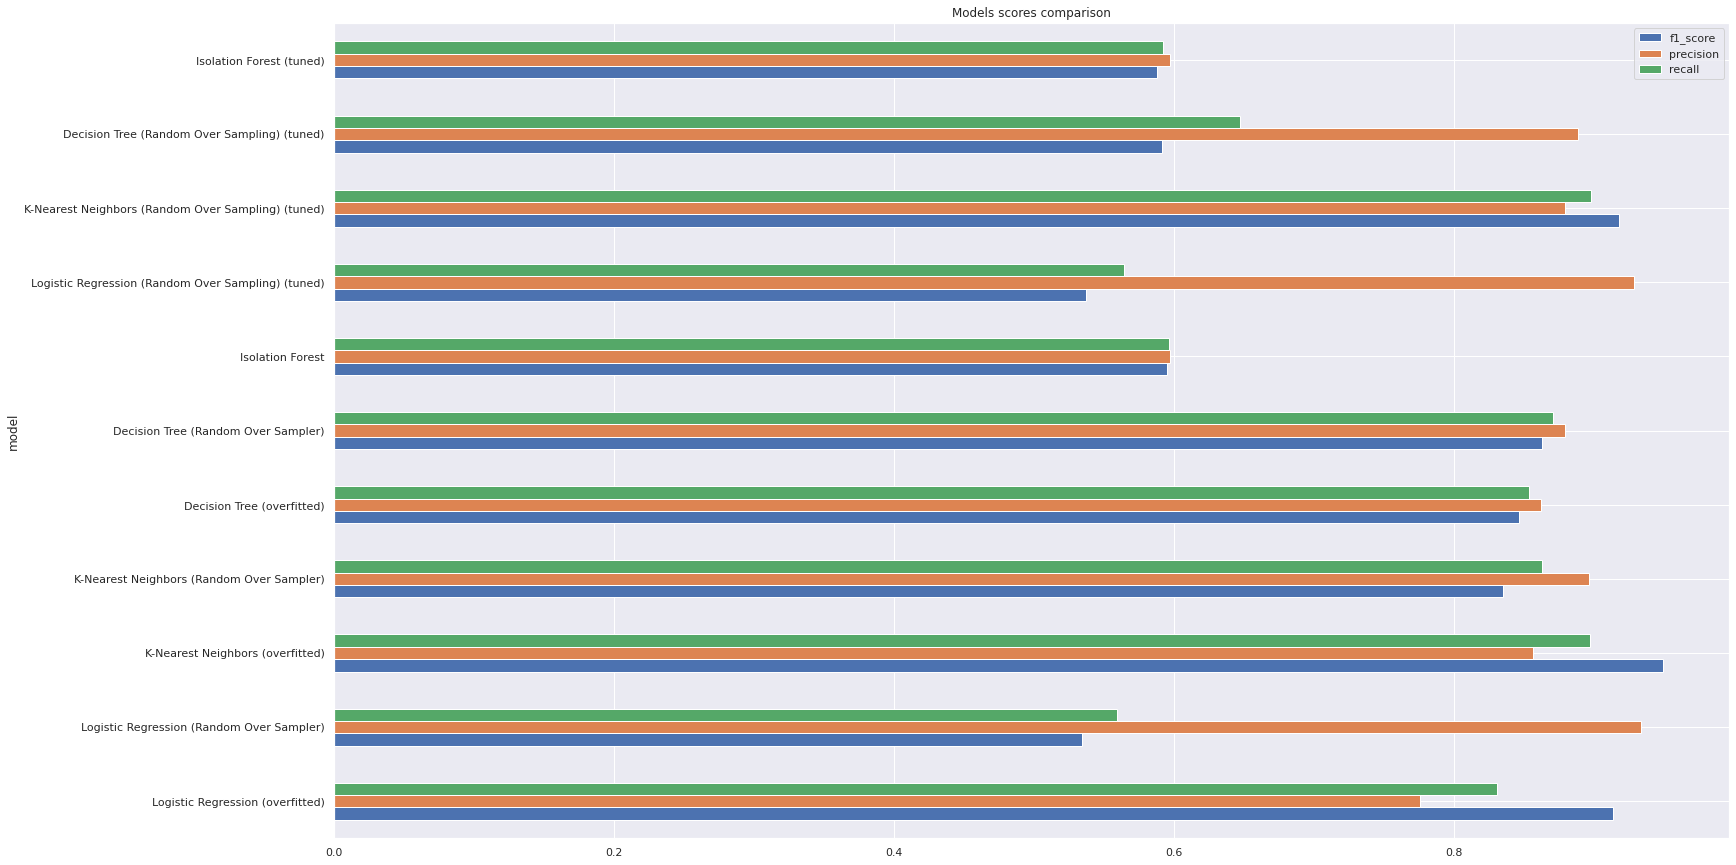

In [60]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(25, 15)
)

ax.set_title('Models scores comparison')
df_scores.plot(kind='barh', x='model', ax=ax)

plt.show()

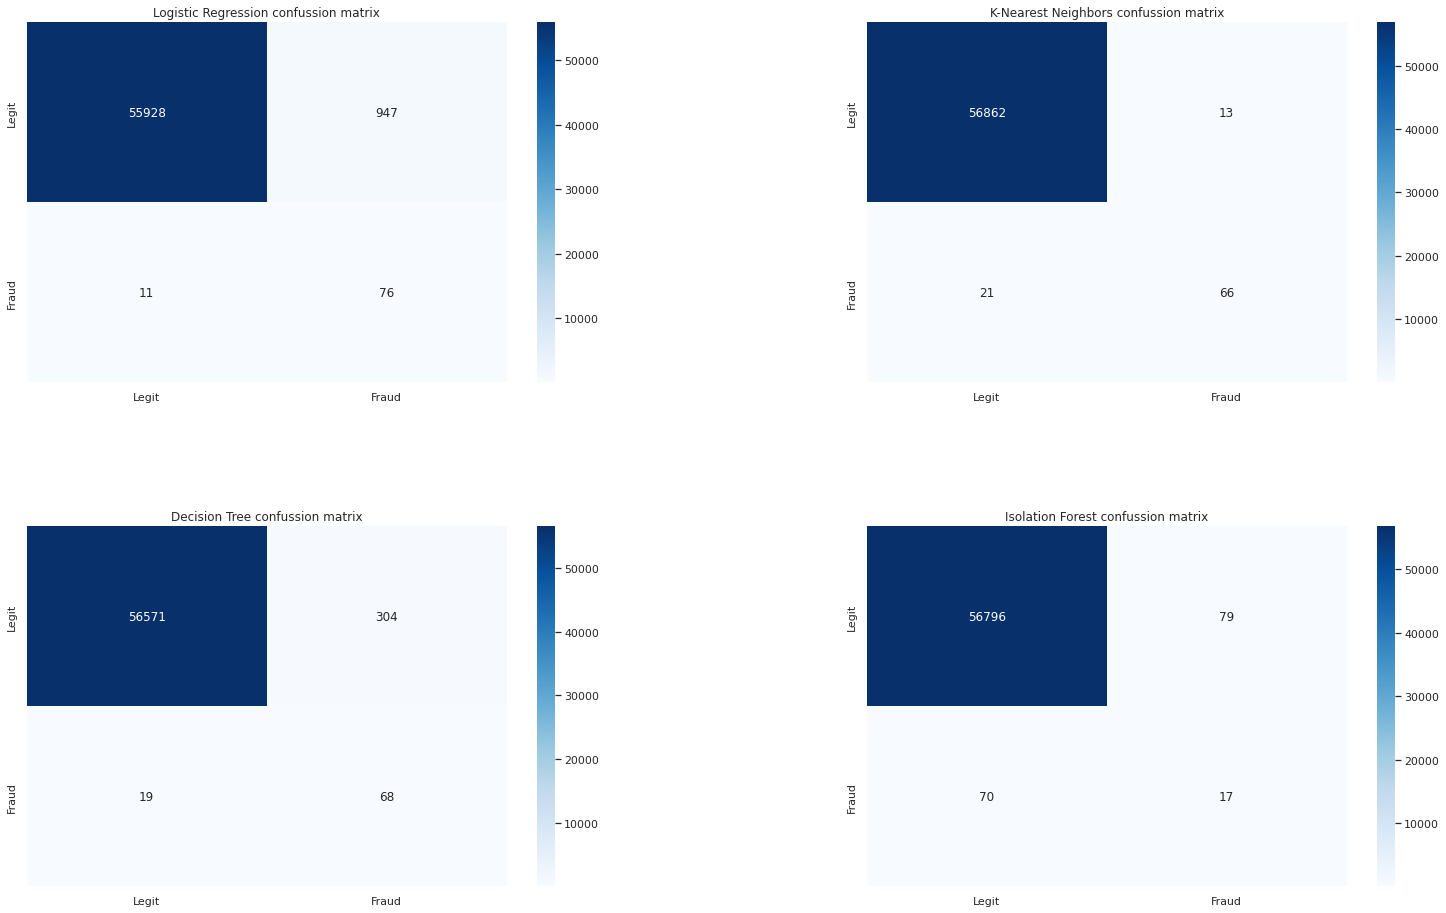

In [61]:

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(25, 15)
)

for model_name, values, ax in zip(
        best_grid_models.keys(),
        best_grid_models.values(),
        axes.flat
):
    _, model_preds = values
    ax.set_title(f'{model_name} confussion matrix')
    cf_matrix = confusion_matrix(y_test, model_preds)
    sns.heatmap(ax=ax, data=cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])

plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.4,
    hspace=0.4,
)
plt.show()

<h3>Persistencia de los modelos</h3>
<p>Una vez obtenidos los binaros de los modelos de este trabajo por último vamos a realizar un proceso de guardado en ficheros binarios para no tener que repetir todo el proceso cada vez que se necesite utilizar los modelos. Para este caso en particular guardaremos todos los modelos que previamente hemos almacenado.</p>


In [62]:
OUTPUT_MODELS_PATH = os.path.join('.', 'models')
Path(OUTPUT_MODELS_PATH).mkdir(parents=True, exist_ok=True)


for model_name, values in best_grid_models.items():
    model, _ = values

    file_name = os.path.join(OUTPUT_MODELS_PATH, f"{model_name.replace(' ', '_').lower()}.joblib")
    print(f'Saving {model_name} as {file_name}...' )
    dump(model, file_name)


Saving Logistic Regression as ./models/logistic_regression.joblib...
Saving K-Nearest Neighbors as ./models/k-nearest_neighbors.joblib...
Saving Decision Tree as ./models/decision_tree.joblib...
Saving Isolation Forest as ./models/isolation_forest.joblib...
